### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.000001
        
        self.batch_size = 32  
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        
        self.states_for_tracking = np.array(env.state_encod_arch1([0,0,0])).reshape(1,36)
        
    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, activation='relu', input_dim=self.state_size))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        #model.summary()
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        return model

    def get_action(self, state):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-0.0005*episode)
        possible_actions_indices, actions = env.requests(state)
        try:
            if np.random.rand() <= self.epsilon:
                # explore: choose a random action from all possible actions
                #print("****", possible_actions_indices)
                return random.choice(possible_actions_indices)
            else:
                # choose the action with the highest q(s, a)
                # the first index corresponds to the batch size, so
                # reshape state to (1, state_size) so that the first index corresponds to the batch size
                encoded_state = env.state_encod_arch1(state)
                encoded_state = encoded_state.reshape(1, self.state_size)
                q_value = self.model.predict(encoded_state)
                q_vals = [q_value[0][i] for i in possible_actions_indices]
                return possible_actions_indices[np.argmax(q_vals)]
        except (IndexError, ValueError) as e:
            print("Error {}".format(e, state))
    def append_sample(self, state, action, reward, next_state, terminal_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, terminal_state))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size,self.state_size))
            update_input = np.zeros((self.batch_size,self.state_size))
            
            actions, rewards, terminal_state = [], [], []
            #Minibatch for training the Q-network 
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal_value = mini_batch[i]
                actions.append(action)
                rewards.append(reward)
                update_input[i] = env.state_encod_arch1(state)
                update_output[i] = env.state_encod_arch1(next_state)
                terminal_state.append(terminal_value)
            # Write your code from here
            # 1. Predict the target from earlier model
            q_vals = self.model.predict(update_output)
            # 2. Get the target for the Q-network
            target = self.model.predict(update_input)
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                #print("Actions[i] {}".format(actions[i]))
                if terminal_state[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i]+ self.discount_factor*max(q_vals[i])
            model_fit = self.model.fit(update_input, target, batch_size=self.batch_size,epochs=5, verbose=0)        
            # 4. Fit your model and track the loss values
            loss = model_fit.history['loss'][2]
            return loss


    def save(self, model_name):
        self.model.save("Final_model")

In [5]:
Episodes = 15000
reward_list = []
q_tracked_state = []
env = CabDriver()
agent = DQNAgent(36, 21)
loss_track = []

### DQN block

In [6]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    env = CabDriver()
    #Call the DQN agent
    count = 0
    terminal_state = False
    state = env.state_init
    total_reward = 0
    #print(state)
    #print("Action inside episodes {}".format(action))
    while not terminal_state:
        count += 1
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state)
        # 2. Evaluate your reward and next state
        reward = env.reward_func(state, env.action_space[action], Time_matrix)
        terminal_state, next_state = env.next_state_func(state, env.action_space[action], Time_matrix)
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        total_reward += reward
        state = next_state
        #print("Terminal state {}, next_state {}". format(terminal_state, next_state))
    reward_list.append(total_reward)
    if episode%20 == 0:
            returned_loss = agent.train_model()
            q_val = agent.model.predict(agent.states_for_tracking)
            # Get the q_value of the action index.
            q_tracked_state.append(q_val[0][2])
            loss_track.append(returned_loss)
            #print(q_tracked_state)
            print("episode {0}, reward {1}, memory_length {2}, epsilon {3} loss {4}"
                  .format(episode, total_reward, len(agent.memory), agent.epsilon, returned_loss))
agent.save('final_model.pkl')

episode 0, reward -205.0, memory_length 138, epsilon 1.0 loss 7.015342712402344
episode 20, reward -291.0, memory_length 2000, epsilon 0.9900498436993344 loss 9.29638671875
episode 40, reward -218.0, memory_length 2000, epsilon 0.9801986931080819 loss 12.044684410095215
episode 60, reward -192.0, memory_length 2000, epsilon 0.9704455631029746 loss 15.167049407958984
episode 80, reward -353.0, memory_length 2000, epsilon 0.960789478362884 loss 7.459531307220459
episode 100, reward -538.0, memory_length 2000, epsilon 0.9512294732712895 loss 4.880451202392578
episode 120, reward -45.0, memory_length 2000, epsilon 0.9417645918197152 loss 6.53618860244751
episode 140, reward -272.0, memory_length 2000, epsilon 0.9323938875121284 loss 6.281036853790283
episode 160, reward 36.0, memory_length 2000, epsilon 0.9231164232702894 loss 9.799057960510254
episode 180, reward -185.0, memory_length 2000, epsilon 0.9139312713400429 loss 7.118597984313965
episode 200, reward -52.0, memory_length 2000, ep

episode 1700, reward 301.0, memory_length 2000, epsilon 0.42741550453379473 loss 42.383663177490234
episode 1720, reward 312.0, memory_length 2000, epsilon 0.4231626591556665 loss 30.44676971435547
episode 1740, reward 234.0, memory_length 2000, epsilon 0.4189521302960897 loss 25.795108795166016
episode 1760, reward 175.0, memory_length 2000, epsilon 0.41478349689866967 loss 56.44800567626953
episode 1780, reward 135.0, memory_length 2000, epsilon 0.4106563420965927 loss 27.441364288330078
episode 1800, reward 85.0, memory_length 2000, epsilon 0.4065702531709393 loss 39.083534240722656
episode 1820, reward 52.0, memory_length 2000, epsilon 0.4025248215094119 loss 48.3255615234375
episode 1840, reward -72.0, memory_length 2000, epsilon 0.398519642565473 loss 14.800790786743164
episode 1860, reward 178.0, memory_length 2000, epsilon 0.3945543158178907 loss 18.311466217041016
episode 1880, reward 301.0, memory_length 2000, epsilon 0.3906284447306857 loss 28.657772064208984
episode 1900, r

episode 3380, reward -432.0, memory_length 2000, epsilon 0.18452033947346527 loss 356.11065673828125
episode 3400, reward -477.0, memory_length 2000, epsilon 0.1826843413692106 loss 111.03498077392578
episode 3420, reward 150.0, memory_length 2000, epsilon 0.18086661175132948 loss 108.10838317871094
episode 3440, reward 545.0, memory_length 2000, epsilon 0.17906696884534531 loss 307.3683166503906
episode 3460, reward 342.0, memory_length 2000, epsilon 0.17728523268546784 loss 208.21893310546875
episode 3480, reward 90.0, memory_length 2000, epsilon 0.17552122509659623 loss 135.6230010986328
episode 3500, reward 634.0, memory_length 2000, epsilon 0.17377476967650168 loss 21.0889835357666
episode 3520, reward 116.0, memory_length 2000, epsilon 0.1720456917781867 loss 46.182186126708984
episode 3540, reward 251.0, memory_length 2000, epsilon 0.1703338184924206 loss 136.30230712890625
episode 3560, reward 668.0, memory_length 2000, epsilon 0.16863897863044822 loss 161.29896545410156
episod

episode 5040, reward 350.0, memory_length 2000, epsilon 0.08046052628992569 loss 41.947296142578125
episode 5060, reward 297.0, memory_length 2000, epsilon 0.07965994062687773 loss 4.4902729988098145
episode 5080, reward 702.0, memory_length 2000, epsilon 0.07886732092427515 loss 143.07781982421875
episode 5100, reward 342.0, memory_length 2000, epsilon 0.07808258791948712 loss 239.19224548339844
episode 5120, reward 1030.0, memory_length 2000, epsilon 0.0773056631385593 loss 253.84130859375
episode 5140, reward 560.0, memory_length 2000, epsilon 0.07653646888836609 loss 49.739891052246094
episode 5160, reward 900.0, memory_length 2000, epsilon 0.07577492824884145 loss 116.64449310302734
episode 5180, reward 359.0, memory_length 2000, epsilon 0.0750209650652869 loss 111.83432006835938
episode 5200, reward 522.0, memory_length 2000, epsilon 0.07427450394075566 loss 393.51861572265625
episode 5220, reward 1032.0, memory_length 2000, epsilon 0.07353547022851334 loss 183.68841552734375
epi

episode 6700, reward 549.0, memory_length 2000, epsilon 0.03508531901649092 loss 87.0440902709961
episode 6720, reward 999.0, memory_length 2000, epsilon 0.03473622420947962 loss 1237.64697265625
episode 6740, reward 747.0, memory_length 2000, epsilon 0.034390602953835364 loss 284.617919921875
episode 6760, reward 470.0, memory_length 2000, epsilon 0.03404842068714461 loss 147.1229248046875
episode 6780, reward 587.0, memory_length 2000, epsilon 0.0337096431908955 loss 13.384915351867676
episode 6800, reward 1003.0, memory_length 2000, epsilon 0.03337423658705612 loss 218.6165008544922
episode 6820, reward 1017.0, memory_length 2000, epsilon 0.033042167334686554 loss 116.5362777709961
episode 6840, reward 1071.0, memory_length 2000, epsilon 0.03271340222658488 loss 8.692376136779785
episode 6860, reward 1078.0, memory_length 2000, epsilon 0.032387908385966266 loss 196.81594848632812
episode 6880, reward 594.0, memory_length 2000, epsilon 0.03206565326317544 loss 147.04417419433594
epis

episode 8340, reward 891.0, memory_length 2000, epsilon 0.01545324467164939 loss 1030.2269287109375
episode 8360, reward 189.0, memory_length 2000, epsilon 0.015299492268217951 loss 12.105926513671875
episode 8380, reward 228.0, memory_length 2000, epsilon 0.015147269726762105 loss 13.226827621459961
episode 8400, reward 243.0, memory_length 2000, epsilon 0.014996561824900882 loss 775.8827514648438
episode 8420, reward 1007.0, memory_length 2000, epsilon 0.014847353491718493 loss 126.395263671875
episode 8440, reward 648.0, memory_length 2000, epsilon 0.014699629806257278 loss 21.56244659423828
episode 8460, reward 692.0, memory_length 2000, epsilon 0.014553375996025573 loss 745.8148193359375
episode 8480, reward -3402.0, memory_length 2000, epsilon 0.014408577435520506 loss 11.610872268676758
episode 8500, reward -1710.0, memory_length 2000, epsilon 0.014265219644765346 loss 12.662843704223633
episode 8520, reward 156.0, memory_length 2000, epsilon 0.01412328828786155 loss 31.29437828

episode 9980, reward 1035.0, memory_length 2000, epsilon 0.006806657686566051 loss 1961.219482421875
episode 10000, reward 573.0, memory_length 2000, epsilon 0.006738940261138468 loss 22.46278190612793
episode 10020, reward 757.0, memory_length 2000, epsilon 0.006671896635351967 loss 24.356143951416016
episode 10040, reward 733.0, memory_length 2000, epsilon 0.006605520104788096 loss 20.73402976989746
episode 10060, reward 733.0, memory_length 2000, epsilon 0.006539804031738493 loss 8.56325912475586
episode 10080, reward 1053.0, memory_length 2000, epsilon 0.006474741844541086 loss 912.7053833007812
episode 10100, reward -3168.0, memory_length 2000, epsilon 0.0064103270369229364 loss 9.98222827911377
episode 10120, reward -1630.0, memory_length 2000, epsilon 0.006346553167349597 loss 14.223257064819336
episode 10140, reward -919.0, memory_length 2000, epsilon 0.006283413858380976 loss 8.29150104522705
episode 10160, reward -207.0, memory_length 2000, epsilon 0.006220902796033557 loss 3

episode 11600, reward 840.0, memory_length 2000, epsilon 0.00302855171782107 loss 20.597265243530273
episode 11620, reward 450.0, memory_length 2000, epsilon 0.0029984270748957564 loss 34.16175079345703
episode 11640, reward 603.0, memory_length 2000, epsilon 0.0029686021771757995 loss 844.8661499023438
episode 11660, reward 703.0, memory_length 2000, epsilon 0.00293907404214657 loss 30.62206268310547
episode 11680, reward 996.0, memory_length 2000, epsilon 0.0029098397169699582 loss 14.473170280456543
episode 11700, reward 1143.0, memory_length 2000, epsilon 0.0028808962781890824 loss 11.07979965209961
episode 11720, reward 529.0, memory_length 2000, epsilon 0.00285224083143595 loss 8.997245788574219
episode 11740, reward 1106.0, memory_length 2000, epsilon 0.0028238705111420024 loss 6.168901443481445
episode 11760, reward 961.0, memory_length 2000, epsilon 0.0027957824802515687 loss 8.649675369262695
episode 11780, reward 873.0, memory_length 2000, epsilon 0.0027679739299381542 loss 

episode 13220, reward 642.0, memory_length 2000, epsilon 0.001347830802579824 loss 22.003530502319336
episode 13240, reward 1106.0, memory_length 2000, epsilon 0.0013344296121824135 loss 9.162311553955078
episode 13260, reward 949.0, memory_length 2000, epsilon 0.0013211617658574165 loss 13.618998527526855
episode 13280, reward 1051.0, memory_length 2000, epsilon 0.0013080259368091424 loss 7.851117134094238
episode 13300, reward 774.0, memory_length 2000, epsilon 0.0012950208114437425 loss 7.270618438720703
episode 13320, reward 1044.0, memory_length 2000, epsilon 0.0012821450892378408 loss 5.0973029136657715
episode 13340, reward 855.0, memory_length 2000, epsilon 0.0012693974826084877 loss 4.904627799987793
episode 13360, reward 909.0, memory_length 2000, epsilon 0.0012567767167843968 loss 5.240168571472168
episode 13380, reward 1066.0, memory_length 2000, epsilon 0.0012442815296784674 loss 9.870833396911621
episode 13400, reward 1142.0, memory_length 2000, epsilon 0.0012319106717615

episode 14820, reward 728.0, memory_length 2000, epsilon 0.0006061700893643586 loss 8.958139419555664
episode 14840, reward 1251.0, memory_length 2000, epsilon 0.0006001485463651526 loss 1004.7633056640625
episode 14860, reward 1124.0, memory_length 2000, epsilon 0.0005941869187198752 loss 7.5539774894714355
episode 14880, reward 376.0, memory_length 2000, epsilon 0.0005882846102607932 loss 8.631521224975586
episode 14900, reward 594.0, memory_length 2000, epsilon 0.0005824410307521434 loss 16.920631408691406
episode 14920, reward 1168.0, memory_length 2000, epsilon 0.0005766555958311046 loss 8.204341888427734
episode 14940, reward 974.0, memory_length 2000, epsilon 0.0005709277269493635 loss 6.3814802169799805
episode 14960, reward 990.0, memory_length 2000, epsilon 0.0005652568513152582 loss 8.87479305267334
episode 14980, reward 1060.0, memory_length 2000, epsilon 0.0005596424018365007 loss 1027.80859375


#### Tracking the state-action pairs for checking convergence (3rd graph below)

In [7]:
# Tracking state (0,0,0) and action (0,2)
states_for_tracking = np.array(env.state_encod_arch1([0,0,0])).reshape(1,36)

### Tracking loss

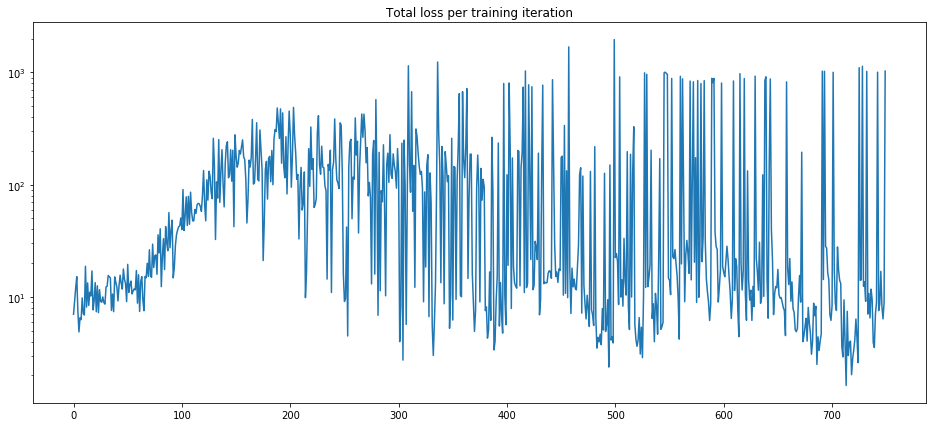

In [9]:
# Tracking loss per training iteration
plt.figure(0, figsize=(16,7))
plt.title('Total loss per training iteration')
x = np.asarray(range(0, len(loss_track)))
plt.semilogy(x,np.asarray(loss_track))
plt.show()

### Tracking Convergence

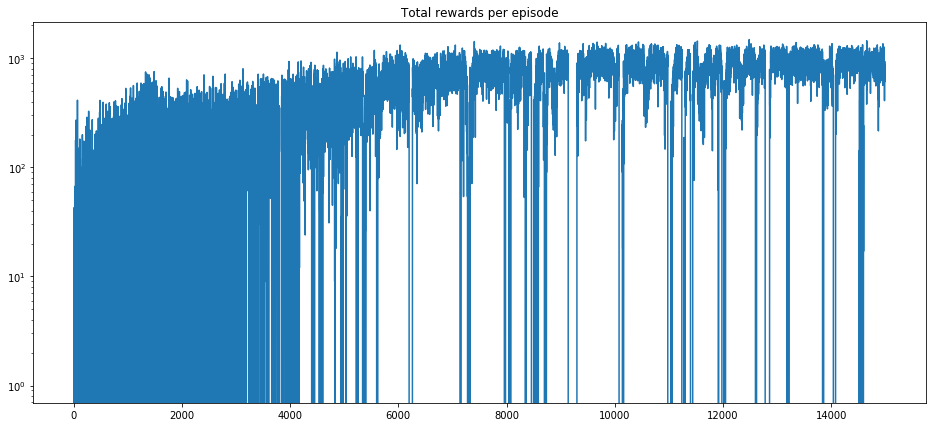

In [10]:
# Tracking total rewards per episode vs episode number
plt.figure(0, figsize=(16,7))
plt.title('Total rewards per episode')
x = np.asarray(range(0, len(reward_list)))
plt.semilogy(x,np.asarray(reward_list))
plt.show()

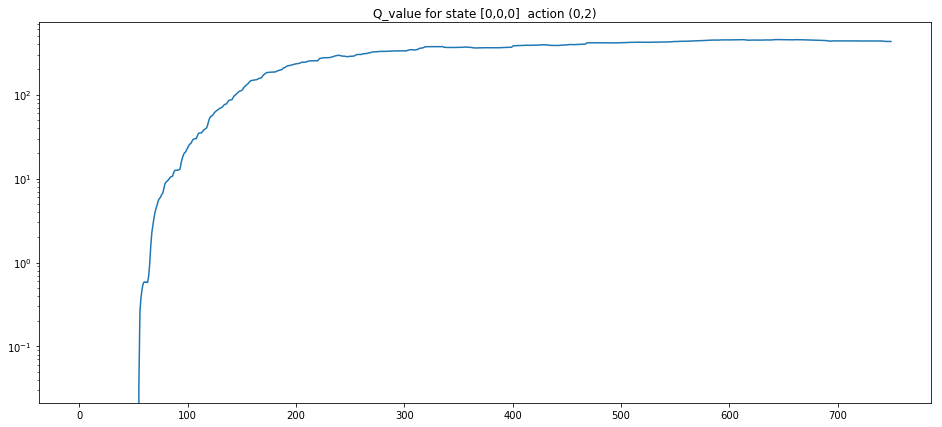

In [11]:
# Tracking Q-value for state [0,0,0] at action (0,2)
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
x = np.asarray(range(0, len(q_tracked_state)))
plt.semilogy(x,np.asarray(q_tracked_state))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [4]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0.000001) * np.exp(-0.0005*i))

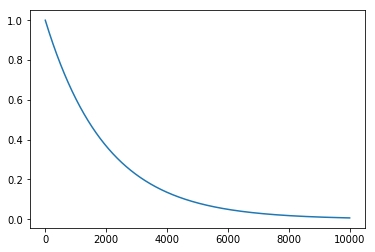

In [5]:
plt.plot(time, epsilon)
plt.show()